# Time Series

To begin, let's look at some time series data plots.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import seaborn as sns

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
!ls data

Gun_Crimes_Heat_Map.csv              google-trends_game-of-thrones_us.csv
google-trends_data-science_us.csv    google-trends_pokemon_us.csv
google-trends_football_uk.csv        google-trends_taxes_us.csv
google-trends_football_us.csv


In [8]:
# Define a function that will help us load and
# clean up a dataset.

def load_trend(trend_name='football', country_code='us'):
    df = pd.read_csv('data/google-trends_'
                     + trend_name + '_'
                     + country_code
                     + '.csv').iloc[1:, :]
    df.columns = ['counts']
    df['counts'] = df['counts'].str.replace('<1', '0').astype(int)
    return df

In [9]:
df = load_trend(**{'trend_name': 'data-science', 'country_code': 'us'})


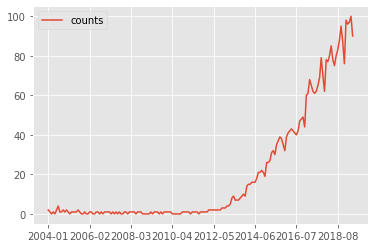

In [10]:
df.plot()

In [11]:
trends = [
    {'trend_name': 'data-science', 'country_code': 'us'},
    {'trend_name': 'football', 'country_code': 'us'},
    {'trend_name': 'football', 'country_code': 'uk'},
    {'trend_name': 'game-of-thrones', 'country_code': 'us'},
    {'trend_name': 'pokemon', 'country_code': 'us'},
    {'trend_name': 'taxes', 'country_code': 'us'},   
]

In [12]:
np.random.shuffle(trends)
trend_dfs = [load_trend(**trend) for trend in trends]

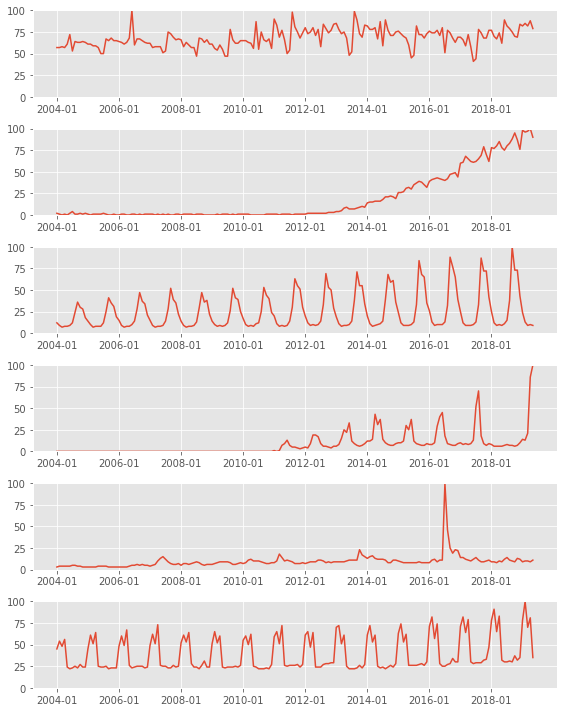

In [13]:
# Let's see if we can guess which is which just by looking
# at their graphs.

fig, axs = plt.subplots(len(trend_dfs), 1, figsize=(8, 10))
plt.tight_layout()
for i, trend_df in enumerate(trend_dfs):
    ax = axs[i]
    #ax.set_title(str(trends[i]))
    ax.plot(np.array(trend_df.index), trend_df['counts'])
    ticks = ax.get_xticks()
    ax.set_ylim((0, 100))
    ax.set_xticks([tick for tick in ticks if tick%24 == 0])

# Time Series vs. Linear Regression

For linear regression, we attempted to explain the variance of a continuous target variable via a set of **independent predictor features**. We assumed that there was no **autocorrelation** amongst our records.  In other words, we did not use the target variable of one row to predict that of another.

In time series models, we make the opposite assumption.  We assume that a given value can best be predicted by its **past values**.

We replace our features with past values of our target. 

# Datetime objects

Let's import some data on **gun violence in Chicago**.

[source](https://data.cityofchicago.org/Public-Safety/Gun-Crimes-Heat-Map/iinq-m3rg)

In [14]:
ts = pd.read_csv('data/Gun_Crimes_Heat_Map.csv')

In [15]:
ts.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,11236423,JB159764,02/10/2018 08:00:00 AM,130XX S LANGLEY AVE,051A,ASSAULT,AGGRAVATED: HANDGUN,STREET,False,False,...,9.0,54,04A,NaN,NaN,2018,02/22/2018 03:58:56 PM,NaN,NaN,NaN
1,10568438,HZ316534,06/20/2016 10:18:00 PM,024XX E 71ST ST,031A,ROBBERY,ARMED: HANDGUN,SIDEWALK,False,False,...,7.0,43,03,NaN,NaN,2016,06/27/2016 03:51:44 PM,NaN,NaN,NaN
2,10394395,HY298019,06/11/2015 08:28:00 PM,058XX S UNION AVE,143A,WEAPONS VIOLATION,UNLAWFUL POSS OF HANDGUN,RESIDENCE,False,False,...,3.0,68,15,NaN,NaN,2015,07/22/2016 03:49:06 PM,NaN,NaN,NaN
3,10370206,HY400660,08/28/2015 11:06:00 AM,039XX W GRENSHAW ST,143A,WEAPONS VIOLATION,UNLAWFUL POSS OF HANDGUN,APARTMENT,False,False,...,24.0,29,15,NaN,NaN,2015,08/04/2016 03:52:47 PM,NaN,NaN,NaN
4,10300408,HY397968,08/26/2015 09:30:00 AM,041XX W MAYPOLE AVE,143A,WEAPONS VIOLATION,UNLAWFUL POSS OF HANDGUN,SIDEWALK,False,False,...,28.0,26,15,NaN,NaN,2015,06/17/2016 03:52:24 PM,NaN,NaN,NaN


Let's look at some summary stats:

In [16]:
ts.shape

(85267, 22)

In [17]:
ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85267 entries, 0 to 85266
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ID                    85267 non-null  int64  
 1   Case Number           85267 non-null  object 
 2   Date                  85267 non-null  object 
 3   Block                 85267 non-null  object 
 4   IUCR                  85267 non-null  object 
 5   Primary Type          85267 non-null  object 
 6   Description           85267 non-null  object 
 7   Location Description  85266 non-null  object 
 8   Arrest                85267 non-null  bool   
 9   Domestic              85267 non-null  bool   
 10  Beat                  85267 non-null  int64  
 11  District              85267 non-null  int64  
 12  Ward                  85266 non-null  float64
 13  Community Area        85267 non-null  int64  
 14  FBI Code              85267 non-null  object 
 15  X Coordinate       

In [19]:
ts.describe()

,ID,Beat,District,Ward,Community Area,X Coordinate,Y Coordinate,Year,Latitude,Longitude
count,8.526700e+04,85267.000000,85267.000000,85266.000000,85267.000000,8.518300e+04,8.518300e+04,85267.000000,85183.000000,85183.000000
mean,1.093513e+07,1033.430155,10.103803,20.195600,42.129511,1.165222e+06,1.877288e+06,2016.952162,41.818862,-87.669466
std,7.311729e+05,633.285758,6.325496,11.641398,19.687047,1.582275e+04,2.908808e+04,1.822765,0.080047,0.057494
min,9.446765e+06,111.000000,1.000000,1.000000,1.000000,1.097414e+06,1.813910e+06,2014.000000,41.644600,-87.917299
25%,1.036662e+07,533.000000,5.000000,9.000000,25.000000,1.152308e+06,1.854690e+06,2016.000000,41.756454,-87.716244
50%,1.100310e+07,915.000000,9.000000,20.000000,42.000000,1.166234e+06,1.872220e+06,2017.000000,41.804936,-87.665853
75%,1.154320e+07,1412.000000,14.000000,28.000000,61.000000,1.177305e+06,1.900567e+06,2018.000000,41.883077,-87.625785
max,1.209136e+07,2535.000000,31.000000,50.000000,77.000000,1.205119e+06,1.951493e+06,2020.000000,42.022536,-87.524541


The data extracts the year of offense as its own column:

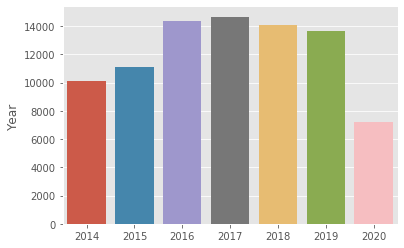

In [20]:
sns.barplot(ts['Year'].value_counts().index,
            ts['Year'].value_counts())
plt.show()

While this does show some interesting information that will be relevant to our time series analysis, we are going to get more granular.

# Date Time Objects

For time series modeling, the first step is to make sure that the index is a date time object.

In [21]:
type(ts.index)

pandas.core.indexes.range.RangeIndex

In [22]:
ts.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,11236423,JB159764,02/10/2018 08:00:00 AM,130XX S LANGLEY AVE,051A,ASSAULT,AGGRAVATED: HANDGUN,STREET,False,False,...,9.0,54,04A,NaN,NaN,2018,02/22/2018 03:58:56 PM,NaN,NaN,NaN
1,10568438,HZ316534,06/20/2016 10:18:00 PM,024XX E 71ST ST,031A,ROBBERY,ARMED: HANDGUN,SIDEWALK,False,False,...,7.0,43,03,NaN,NaN,2016,06/27/2016 03:51:44 PM,NaN,NaN,NaN
2,10394395,HY298019,06/11/2015 08:28:00 PM,058XX S UNION AVE,143A,WEAPONS VIOLATION,UNLAWFUL POSS OF HANDGUN,RESIDENCE,False,False,...,3.0,68,15,NaN,NaN,2015,07/22/2016 03:49:06 PM,NaN,NaN,NaN
3,10370206,HY400660,08/28/2015 11:06:00 AM,039XX W GRENSHAW ST,143A,WEAPONS VIOLATION,UNLAWFUL POSS OF HANDGUN,APARTMENT,False,False,...,24.0,29,15,NaN,NaN,2015,08/04/2016 03:52:47 PM,NaN,NaN,NaN
4,10300408,HY397968,08/26/2015 09:30:00 AM,041XX W MAYPOLE AVE,143A,WEAPONS VIOLATION,UNLAWFUL POSS OF HANDGUN,SIDEWALK,False,False,...,28.0,26,15,NaN,NaN,2015,06/17/2016 03:52:24 PM,NaN,NaN,NaN


There are a few ways to **reindex** our series to datetime. 

We can use the pd.to_datetime() method

In [23]:
ts.set_index(pd.to_datetime(ts['Date']), drop=True, inplace=True)

Or, we can parse the dates directly on import

In [24]:
ts = pd.read_csv('data/Gun_Crimes_Heat_Map.csv',
                 index_col='Date',
                 parse_dates=True)

In [25]:
type(ts.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [26]:
ts.head()

,ID,Case Number,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
Date,,,,,,,,,,,,,,,,,,,,,
2018-02-10 08:00:00,11236423,JB159764,130XX S LANGLEY AVE,051A,ASSAULT,AGGRAVATED: HANDGUN,STREET,False,False,533,...,9.0,54,04A,NaN,NaN,2018,02/22/2018 03:58:56 PM,NaN,NaN,NaN
2016-06-20 22:18:00,10568438,HZ316534,024XX E 71ST ST,031A,ROBBERY,ARMED: HANDGUN,SIDEWALK,False,False,334,...,7.0,43,03,NaN,NaN,2016,06/27/2016 03:51:44 PM,NaN,NaN,NaN
2015-06-11 20:28:00,10394395,HY298019,058XX S UNION AVE,143A,WEAPONS VIOLATION,UNLAWFUL POSS OF HANDGUN,RESIDENCE,False,False,711,...,3.0,68,15,NaN,NaN,2015,07/22/2016 03:49:06 PM,NaN,NaN,NaN
2015-08-28 11:06:00,10370206,HY400660,039XX W GRENSHAW ST,143A,WEAPONS VIOLATION,UNLAWFUL POSS OF HANDGUN,APARTMENT,False,False,1132,...,24.0,29,15,NaN,NaN,2015,08/04/2016 03:52:47 PM,NaN,NaN,NaN
2015-08-26 09:30:00,10300408,HY397968,041XX W MAYPOLE AVE,143A,WEAPONS VIOLATION,UNLAWFUL POSS OF HANDGUN,SIDEWALK,False,False,1114,...,28.0,26,15,NaN,NaN,2015,06/17/2016 03:52:24 PM,NaN,NaN,NaN


Datetime objects have fun capabilities, including being able to extract components of the date like so:

In [27]:
ts.index[0].month

2

In [28]:
ts.index[0].year

2018

In [29]:
ts.index[0].day

10

Now we have new abilities, such as **resampling**

To create our timeseries, we will count the number of gun offenses reported per day.

In [33]:
ts.resample('D')

Take a moment to familiarize yourself with the differnece resampling aliases

<table style="display: inline-block">
    <caption style="text-align: center"><strong>TIME SERIES OFFSET ALIASES</strong></caption>
<tr><th>ALIAS</th><th>DESCRIPTION</th></tr>
<tr><td>B</td><td>business day frequency</td></tr>
<tr><td>C</td><td>custom business day frequency (experimental)</td></tr>
<tr><td>D</td><td>calendar day frequency</td></tr>
<tr><td>W</td><td>weekly frequency</td></tr>
<tr><td>M</td><td>month end frequency</td></tr>
<tr><td>SM</td><td>semi-month end frequency (15th and end of month)</td></tr>
<tr><td>BM</td><td>business month end frequency</td></tr>
<tr><td>CBM</td><td>custom business month end frequency</td></tr>
<tr><td>MS</td><td>month start frequency</td></tr>
<tr><td>SMS</td><td>semi-month start frequency (1st and 15th)</td></tr>
<tr><td>BMS</td><td>business month start frequency</td></tr>
<tr><td>CBMS</td><td>custom business month start frequency</td></tr>
<tr><td>Q</td><td>quarter end frequency</td></tr>
<tr><td></td><td><font color=white>intentionally left blank</font></td></tr></table>

<table style="display: inline-block; margin-left: 40px">
<caption style="text-align: center"></caption>
<tr><th>ALIAS</th><th>DESCRIPTION</th></tr>
<tr><td>BQ</td><td>business quarter endfrequency</td></tr>
<tr><td>QS</td><td>quarter start frequency</td></tr>
<tr><td>BQS</td><td>business quarter start frequency</td></tr>
<tr><td>A</td><td>year end frequency</td></tr>
<tr><td>BA</td><td>business year end frequency</td></tr>
<tr><td>AS</td><td>year start frequency</td></tr>
<tr><td>BAS</td><td>business year start frequency</td></tr>
<tr><td>BH</td><td>business hour frequency</td></tr>
<tr><td>H</td><td>hourly frequency</td></tr>
<tr><td>T, min</td><td>minutely frequency</td></tr>
<tr><td>S</td><td>secondly frequency</td></tr>
<tr><td>L, ms</td><td>milliseconds</td></tr>
<tr><td>U, us</td><td>microseconds</td></tr>
<tr><td>N</td><td>nanoseconds</td></tr></table>

When resampling, we have to provide a rule to resample by and an [**aggregate function**](https://pandas.pydata.org/pandas-docs/stable/reference/resampling.html#computations-descriptive-stats).

**To upsample** is to increase the frequency of the data of interest.  
**To downsample** is to decrease the frequency of the data of interest.

For our purposes, we will downsample, and  count the number of occurences per day.

In [36]:
ts.resample('D').count()

,ID,Case Number,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-01,50,50,50,50,50,50,50,50,50,50,...,50,50,50,50,50,50,50,50,50,50
2014-01-02,33,33,33,33,33,33,33,33,33,33,...,33,33,33,33,33,33,33,33,33,33
2014-01-03,24,24,24,24,24,24,24,24,24,24,...,24,24,24,24,24,24,24,24,24,24
2014-01-04,32,32,32,32,32,32,32,32,32,32,...,32,32,32,32,32,32,32,32,32,32
2014-01-05,17,17,17,17,17,17,17,17,17,17,...,17,17,17,17,17,17,17,17,17,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-21,52,52,52,52,52,52,52,52,52,52,...,52,52,52,52,52,52,52,52,52,52
2020-06-22,66,66,66,66,66,66,66,66,66,66,...,66,66,66,66,66,66,66,66,66,66
2020-06-23,48,48,48,48,48,48,48,48,48,48,...,48,48,48,48,48,48,48,48,48,48


Our time series will consist of a series of counts of gun reports per day.

In [37]:
# ID is unimportant. We could have chosen any column,
# since the counts are the same.
ts = ts.resample('D').count()['ID']

In [38]:
ts

Date
2014-01-01    50
2014-01-02    33
2014-01-03    24
2014-01-04    32
2014-01-05    17
              ..
2020-06-21    52
2020-06-22    66
2020-06-23    48
2020-06-24    58
2020-06-25    46
Freq: D, Name: ID, Length: 2368, dtype: int64

Let's visualize our timeseries with a plot.

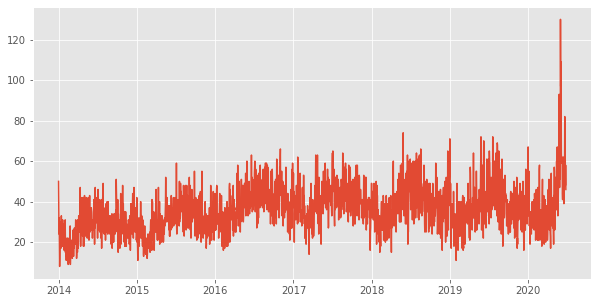

In [39]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(ts.index, ts.values)

There seems to be some abnormal activity happening towards the end of our series.

**[sun-times](https://chicago.suntimes.com/crime/2020/6/8/21281998/chicago-deadliest-day-violence-murder-history-police-crime)**

In [40]:
ts.sort_values(ascending=False)[:10]

Date
2020-05-31    130
2020-06-02    109
2020-06-01     97
2020-06-03     95
2020-05-25     93
2020-06-20     82
2020-05-24     77
2018-05-28     74
2019-05-26     72
2019-07-20     72
Name: ID, dtype: int64

Let's treat the span of days from 5-31 to 6-03 as outliers. 

There are several ways to do this, but let's first remove the outliers, and populate an an empty array with the original date range.  That will introduce us to the pd.date_range method.

In [41]:
daily_count = ts[ts < 90]
ts_dr = pd.date_range(daily_count.index[0], daily_count.index[-1])
ts_daily = np.empty(shape=len(ts_dr))
ts_daily = pd.Series(ts_daily)
ts_daily = ts_daily.reindex(ts_dr)
ts = ts_daily.fillna(daily_count)

In [45]:
ts[-36:-20]

2020-05-21    46.0
2020-05-22    48.0
2020-05-23    68.0
2020-05-24    77.0
2020-05-25     NaN
2020-05-26    56.0
2020-05-27    47.0
2020-05-28    58.0
2020-05-29    54.0
2020-05-30    51.0
2020-05-31     NaN
2020-06-01     NaN
2020-06-02     NaN
2020-06-03     NaN
2020-06-04    64.0
2020-06-05    60.0
Freq: D, dtype: float64

Text(0.5, 1.0, 'Gun Crimes in Chicago with Deadliest Days Removed')

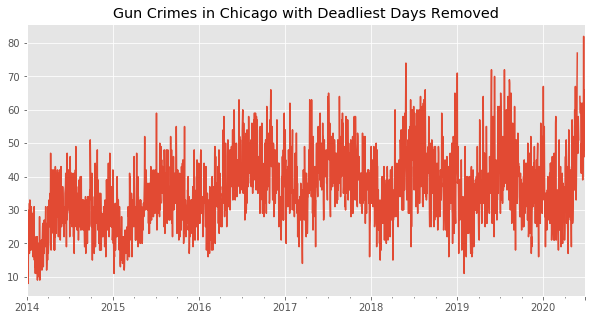

In [46]:
fig, ax = plt.subplots(figsize=(10, 5))
ts.plot(ax=ax)
ax.set_title('Gun Crimes in Chicago with Deadliest Days Removed')

Let's zoom in on that week again

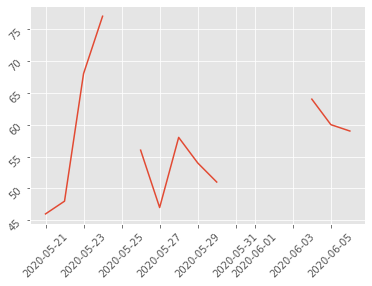

In [47]:
fig, ax = plt.subplots()
ax.plot(ts[(ts.index > '2020-05-20')
           & (ts.index < '2020-06-07')])
ax.tick_params(rotation=45)

The datetime object allows us several options of how to fill those gaps:

Text(0.5, 1.0, 'Original')

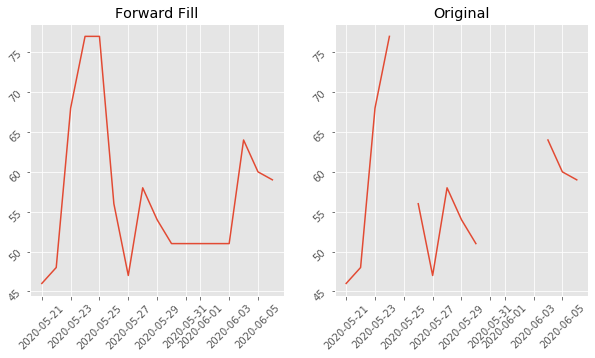

In [48]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(ts.ffill()[(ts.index > '2020-05-20')
                    & (ts.index < '2020-06-07')])
ax1.tick_params(rotation=45)
ax1.set_title('Forward Fill')

ax2.plot(ts[(ts.index > '2020-05-20')
            & (ts.index < '2020-06-07')])
ax2.tick_params(rotation=45)
ax2.set_title('Original')

Text(0.5, 1.0, 'Original')

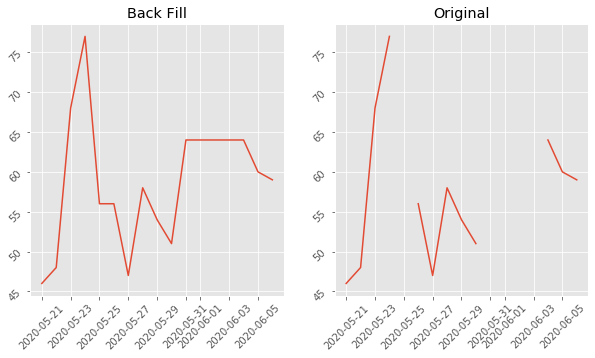

In [49]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (10,5))
ax1.plot(ts.bfill()[(ts.index > '2020-05-20') 
                 & (ts.index < '2020-06-07')])
ax1.tick_params(rotation=45)
ax1.set_title('Back Fill')

ax2.plot(ts[(ts.index > '2020-05-20') 
                 & (ts.index < '2020-06-07')])
ax2.tick_params(rotation=45)
ax2.set_title('Original')

Text(0.5, 1.0, 'Original')

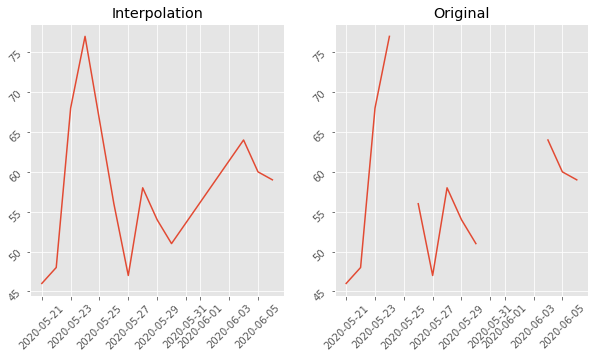

In [50]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(ts.interpolate()[(ts.index > '2020-05-20')
                          & (ts.index < '2020-06-07')])
ax1.tick_params(rotation=45)
ax1.set_title('Interpolation')

ax2.plot(ts[(ts.index > '2020-05-20')
            & (ts.index < '2020-06-07')])
ax2.tick_params(rotation=45)
ax2.set_title('Original')

Let's proceed with the interpolated data

In [51]:
ts = ts.interpolate()
ts.isna().sum()

0

Let's begin considering some models for our data.

These are not useful for prediction just yet, but they will lead us towards our prediction models.

Now that we've cleaned up a few data points, let's downsample to the week level.  

In [52]:
ts_weekly = ts.resample('W').mean()

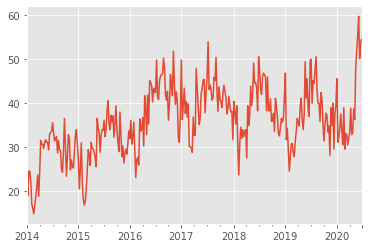

In [53]:
ts_weekly.plot()

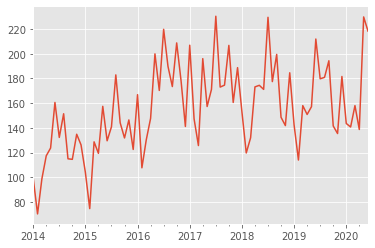

In [57]:
ts_weekly.resample('M').sum().plot()

# Visual Diagnostics with SMA and EWMA

# Simple Moving Average

A simple moving average consists of an average across a specified window of time. 

The datetime index allows us to calculate simple moving averages via the rolling function.

The rolling function calculates a statistic across a moving **window**, which we can change with the window paraamter.

In [58]:
ts_weekly.rolling(window=4)

Rolling [window=4,center=False,axis=0]

Let's calculate a month long moving average

In [61]:
ts_weekly.rolling(4).mean()[:10]

2014-01-05          NaN
2014-01-12          NaN
2014-01-19          NaN
2014-01-26    24.835714
2014-02-02    22.607143
2014-02-09    22.142857
2014-02-16    20.035714
2014-02-23    17.607143
2014-03-02    16.214286
2014-03-09    16.607143
Freq: W-SUN, dtype: float64

This is simply the avarage of a datapoint and the previous three data points:

In [65]:
ts_weekly[1:5]

2014-01-12    19.000000
2014-01-19    24.571429
2014-01-26    24.571429
2014-02-02    22.285714
Freq: W-SUN, dtype: float64

In [66]:
ts_weekly[1:5].mean() 

22.607142857142854

In [67]:
ts_weekly[:4].mean() == ts_weekly.rolling(4).mean()[3]

True

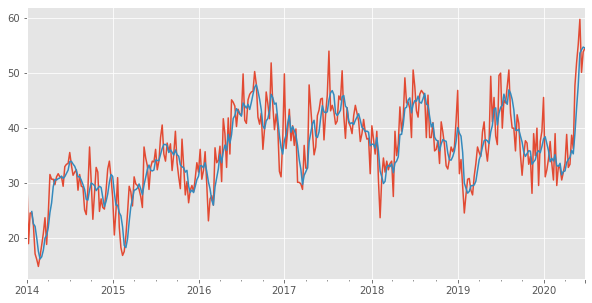

In [68]:
sma_week = ts_weekly.rolling(4).mean()

fig, ax = plt.subplots(figsize=(10,5))

ts_weekly.plot(ax=ax)
sma_week.plot(ax=ax)


As we can see from the plot below, simple moving average **smooths** out the series. Smoothing can help visualize the underlying pattern.  It can also be a very simple predictive model, where we just project the mean out into the future.

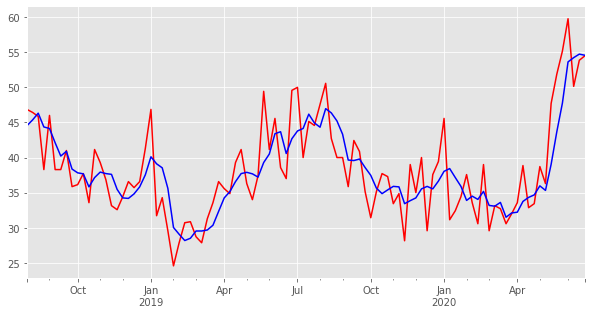

In [69]:
# Let's zoom in

fig, ax = plt.subplots(figsize=(10,5))

ts_weekly[-100:].plot(ax=ax, c='r')
sma_week[-100:].plot(ax=ax, c='b')


The simple moving avereage tracks fairly well, but does not reach to the peaks and valleys of the original distribution.

If we plot the moving average across 52 weeeks, we can see a smooth trend across a year.  The SMA reaches back 52 weeks, shwing that the steepest growth of gun crime started around the beginning of 2016 and leveled out at the beginning of 2017.

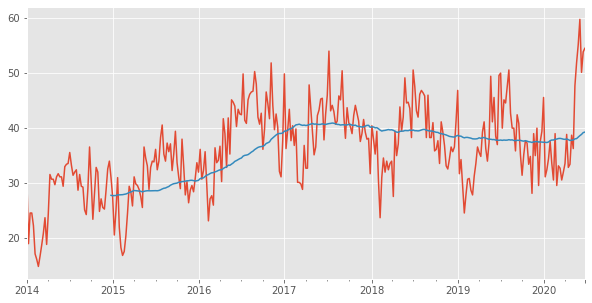

In [70]:
sma_week = ts_weekly.rolling(52).mean()

fig, ax = plt.subplots(figsize=(10,5))

ts_weekly.plot(ax=ax)
sma_week.plot(ax=ax)

# EWMA
## Exponentially Weighted Moving Average 

An alternative to SMA is the EWMA. The exponentially weighted average gives more weight to the points closer to the date in question.  With EWMA, the average will track more closely to the peaks and valleys. If there are extreme historical values in the dataset, the EWMA will be less skewed than the SMA.


$\large d^3 * X_{t-3} + d^2 * X_{t-2} + d^1 * X_{t-1}+ (1-d)*X_t$

In [71]:
ts_ex_ewm = ts_weekly.ewm(alpha=.5).mean()[:10]
ts_ex_ewm

2014-01-05    31.200000
2014-01-12    23.066667
2014-01-19    23.926531
2014-01-26    24.270476
2014-02-02    23.246083
2014-02-09    20.146032
2014-02-16    18.128684
2014-02-23    16.486499
2014-03-02    16.600615
2014-03-09    17.658483
Freq: W-SUN, dtype: float64

The higher the $\alpha$ parameter, the closer the EWMA will be to the actual value of the point.

In [72]:
ts_ex_ewm = ts_weekly.ewm(alpha=.99).mean()[:10]
ts_ex_ewm

2014-01-05    31.200000
2014-01-12    19.120792
2014-01-19    24.516928
2014-01-26    24.570884
2014-02-02    22.308566
2014-02-09    17.194514
2014-02-16    16.153374
2014-02-23    14.870105
2014-03-02    16.695844
2014-03-09    18.694101
Freq: W-SUN, dtype: float64

In [73]:
ts_weekly[:10]

2014-01-05    31.200000
2014-01-12    19.000000
2014-01-19    24.571429
2014-01-26    24.571429
2014-02-02    22.285714
2014-02-09    17.142857
2014-02-16    16.142857
2014-02-23    14.857143
2014-03-02    16.714286
2014-03-09    18.714286
Freq: W-SUN, dtype: float64

Let's plot our rolling statistics with some different windows

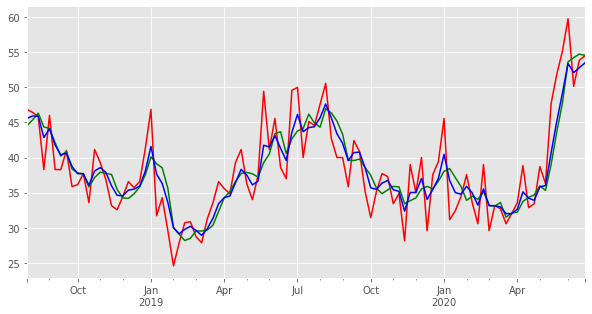

In [74]:
fig, ax = plt.subplots(figsize=(10,5))

ts_weekly[-100:].plot(ax=ax, c='r', label='Original')
ts_weekly.rolling(4).mean().dropna()[-100:].plot(ax=ax, c='g', label='SMA')
ts_weekly.ewm(span=4).mean().dropna()[-100:].plot(ax=ax, c='b', label='EWMA')

Again, if we zoom in to the year level, we can see peaks and valleys according to the seasons.  

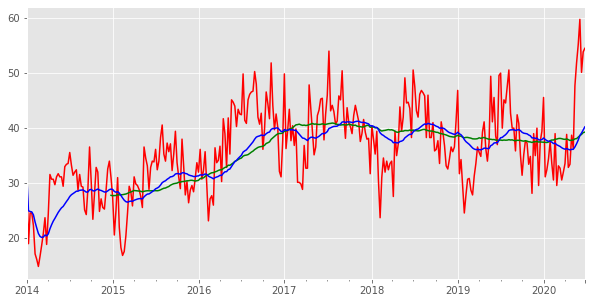

In [75]:
fig, ax = plt.subplots(figsize=(10,5))

ts_weekly.plot(ax=ax, c='r', label='Original')
ts_weekly.rolling(52).mean().dropna().plot(ax=ax, c='g', label='SMA')
ts_weekly.ewm(span=52).mean().dropna().plot(ax=ax, c='b', label='EWMA')

### Components of Time Series Data
A time series in general is supposed to be affected by four main components, which can be separated from the observed data. These components are: *Trend, Cyclical, Seasonal and Irregular* components.

- **Trend** : The long term movement of a time series. For example, series relating to population growth, number of houses in a city etc. show upward trend.
- **Seasonality** : Fluctuation in the data set that follow a regular pattern due to outside influences. For example sales of ice-cream increase in summer, or daily web traffic.
- **Cyclical** : When data exhibit rises and falls that are not of fixed period.  Think of business cycles which usually last several years, but where the length of the current cycle is unknown beforehand.
- **Irregular**: Are caused by unpredictable influences, which are not regular and also do not repeat in a particular pattern. These variations are caused by incidences such as war, strike, earthquake, flood, revolution, etc. There is no defined statistical technique for measuring random fluctuations in a time series.


*Note: Many people confuse cyclic behaviour with seasonal behaviour, but they are really quite different. If the fluctuations are not of fixed period then they are cyclic; if the period is unchanging and associated with some aspect of the calendar, then the pattern is seasonal.*

The statsmodels seasonal decompose can also help show us the trends in our data.

<Figure size 432x288 with 0 Axes>

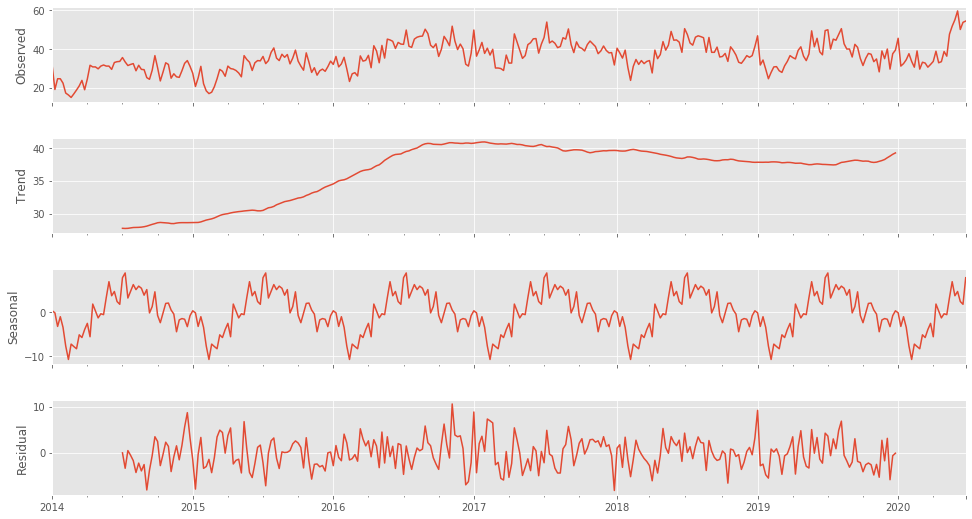

In [76]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_weekly)
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(15, 8)

### Statistical stationarity: 

When building our models, we will want to account for these trends somehow.  Time series whose mean and variance have trends across time will be difficult to predict out into the future. 

A **stationary time series** is one whose statistical properties such as mean, variance, autocorrelation, etc. are all constant over time. Most statistical forecasting methods are based on the assumption that the time series can be rendered approximately stationary (i.e., "stationarized") through the use of mathematical transformations. A stationarized series is relatively easy to predict: you simply predict that its statistical properties will be the same in the future as they have been in the past!  


<h3 style="text-align: center;">Constant Mean</p>



<img src='img/mean_nonstationary.webp'/>

<h3 style="text-align: center;">Constant Variance</p>


<img src='img/variance_nonstationary.webp'/>


<h3 style="text-align: center;">Constant Covariance</p>


<img src='img/covariance_nonstationary.webp'/>

While we can get a sense of how stationary our data is with visuals, the Dickey Fuller test gives us a quantitatitive measure.

Here the null hypothesis is that the TS is non-stationary. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary.

In [77]:
from statsmodels.tsa.stattools import adfuller

# create a function that will help us to quickly


def test_stationarity(timeseries, window):

    # Determing rolling statistics
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()

    # Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries.iloc[window:], color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=[
                         'Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

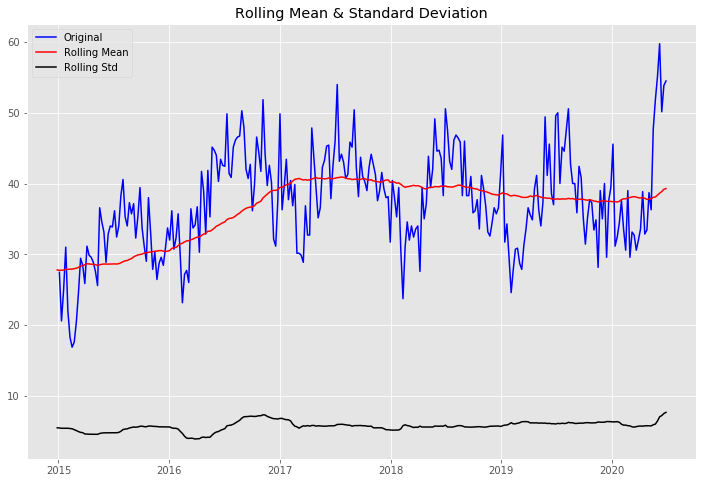

Results of Dickey-Fuller Test:
Test Statistic                  -2.562238
p-value                          0.101056
#Lags Used                       4.000000
Number of Observations Used    334.000000
Critical Value (1%)             -3.450081
Critical Value (5%)             -2.870233
Critical Value (10%)            -2.571401
dtype: float64


In [78]:
test_stationarity(ts_weekly, 52)

As we concluded visually, our original timeseries does not pass the test of stationarity.

### How to stationarize time series data

A series of steps can be taken to stationarize your data - also known -  as removing trends (linear trends, seasonaility/periodicity, etc - more details on transformations <a href='http://people.duke.edu/~rnau/whatuse.htm'>here</a>).


One way to remove trends is to difference our data.  
Differencing is performed by subtracting the previous observation (lag=1) from the current observation.

In [80]:
ts_weekly.diff().dropna()[:5]

2014-01-12   -12.200000
2014-01-19     5.571429
2014-01-26     0.000000
2014-02-02    -2.285714
2014-02-09    -5.142857
Freq: W-SUN, dtype: float64

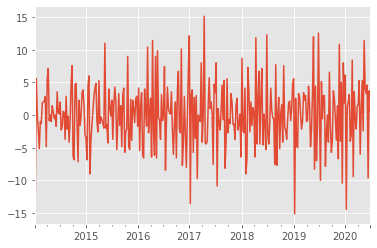

In [81]:
ts_weekly.diff().dropna().plot()

Sometimes, we have to difference the differenced data (known as a second difference) to achieve stationary data. <b>The number of times we have to difference our data is the order of differencing</b> - we will use this information when building our model.

In [82]:
#Second order difference:

ts_weekly.diff().diff().dropna()[:5]

2014-01-19    17.771429
2014-01-26    -5.571429
2014-02-02    -2.285714
2014-02-09    -2.857143
2014-02-16     4.142857
Freq: W-SUN, dtype: float64

In [83]:
# We can also apply seasonal differences:
    
ts_weekly.diff(52).dropna()[:10]

2015-01-04   -3.771429
2015-01-11    1.571429
2015-01-18    0.428571
2015-01-25    6.428571
2015-02-01   -0.285714
2015-02-08    1.142857
2015-02-15    0.714286
2015-02-22    2.714286
2015-03-01    3.714286
2015-03-08    5.857143
Freq: W-SUN, dtype: float64

Let's difference our data and see if it improves Dickey-Fuller Test

In [ ]:
ts_weekly.diff().dropna()

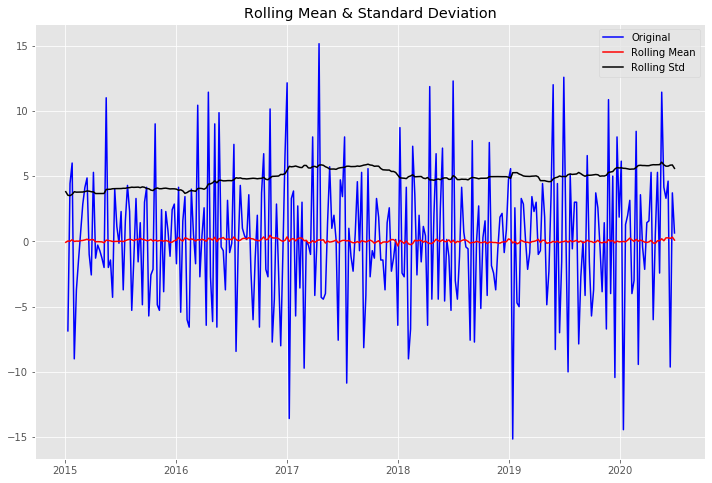

Results of Dickey-Fuller Test:
Test Statistic                -1.322052e+01
p-value                        1.003933e-24
#Lags Used                     3.000000e+00
Number of Observations Used    3.340000e+02
Critical Value (1%)           -3.450081e+00
Critical Value (5%)           -2.870233e+00
Critical Value (10%)          -2.571401e+00
dtype: float64


In [84]:
test_stationarity(ts_weekly.diff().dropna(), 52)

One we have achieved stationarity the next step in fitting a model to address any autocorrelation that remains in the differenced series. 

Sometimes, we have to difference the differenced data (known as a second difference) to achieve stationary data. <b>The number of times we have to difference our data is the order of differencing</b> - we will use this information when building our model.

One we have achieved stationarity the next step in fitting a model is to address any autocorrelation that remains in the differenced series. 